# Question B3 (10 marks)

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [1]:
!pip install captum

In [2]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

/Users/ngtzekean/Github/SC4001-Neural-Network-Deep-Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [3]:
# YOUR CODE HERE
df = pd.read_csv("hdb_price_prediction.csv")

train_data = df[df["year"] <= 2019]
validation_data = df[df["year"] == 2020]
test_data = df[df["year"] == 2021]

# Drop all categorical features
target = ["resale_price"]
continuous_cols = [
    "dist_to_nearest_stn",
    "dist_to_dhoby",
    "degree_centrality",
    "eigenvector_centrality",
    "remaining_lease_years",
    "floor_area_sqm",
]
categorical_cols = ["month", "town", "flat_model_type", "storey_range"]

train_data = train_data[continuous_cols + target]
validation_data = validation_data[continuous_cols + target]
test_data = test_data[continuous_cols + target]

2.Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [4]:
# YOUR CODE HERE
batch_size = 64
num_epochs = 100
learning_rate = 0.001
size_hidden1 = 5
size_hidden2 = 5
size_hidden3 = 5
no_labels = 1

from torch.utils.data import DataLoader, TensorDataset

# Convert dataframes to PyTorch tensors
X_train = torch.tensor(train_data[continuous_cols].values).float()
y_train = torch.tensor(train_data[target].values).view(-1, 1).float()

X_val = torch.tensor(validation_data[continuous_cols].values).float()
y_val = torch.tensor(validation_data[target].values).view(-1, 1).float()

X_test = torch.tensor(test_data[continuous_cols].values).float()
y_test = torch.tensor(test_data[target].values).view(-1, 1).float()

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
class HDBResaleModel(nn.Module):
    def __init__(self, no_features, no_hidden1, no_hidden2, no_hidden3, no_labels):
        super().__init__()
        self.lin1 = nn.Linear(no_features, no_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(no_hidden1, no_hidden2)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(no_hidden2, no_hidden3)
        self.relu3 = nn.ReLU()
        self.lin4 = nn.Linear(no_hidden3, no_labels)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

In [6]:
model = HDBResaleModel(X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
def train(model_inp, num_epochs, optimizer, loss_fn, dataloader):
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader:
            outputs = model_inp(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()
        if epoch % 20 == 0:    
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 201799704354816.000
Epoch [21]/[100] running accumulative loss across all batches: 5766967707648.000
Epoch [41]/[100] running accumulative loss across all batches: 4850517085056.000
Epoch [61]/[100] running accumulative loss across all batches: 4610337007616.000
Epoch [81]/[100] running accumulative loss across all batches: 4494039289088.000


In [8]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation

sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test)
ixg_attr_test = ixg.attribute(X_test)
ig_attr_test = ig.attribute(X_test, n_steps=50)

# Entire training set used for the distribution of baselines

gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/Users/ngtzekean/Github/SC4001-Neural-Network-Deep-Learning/.venv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


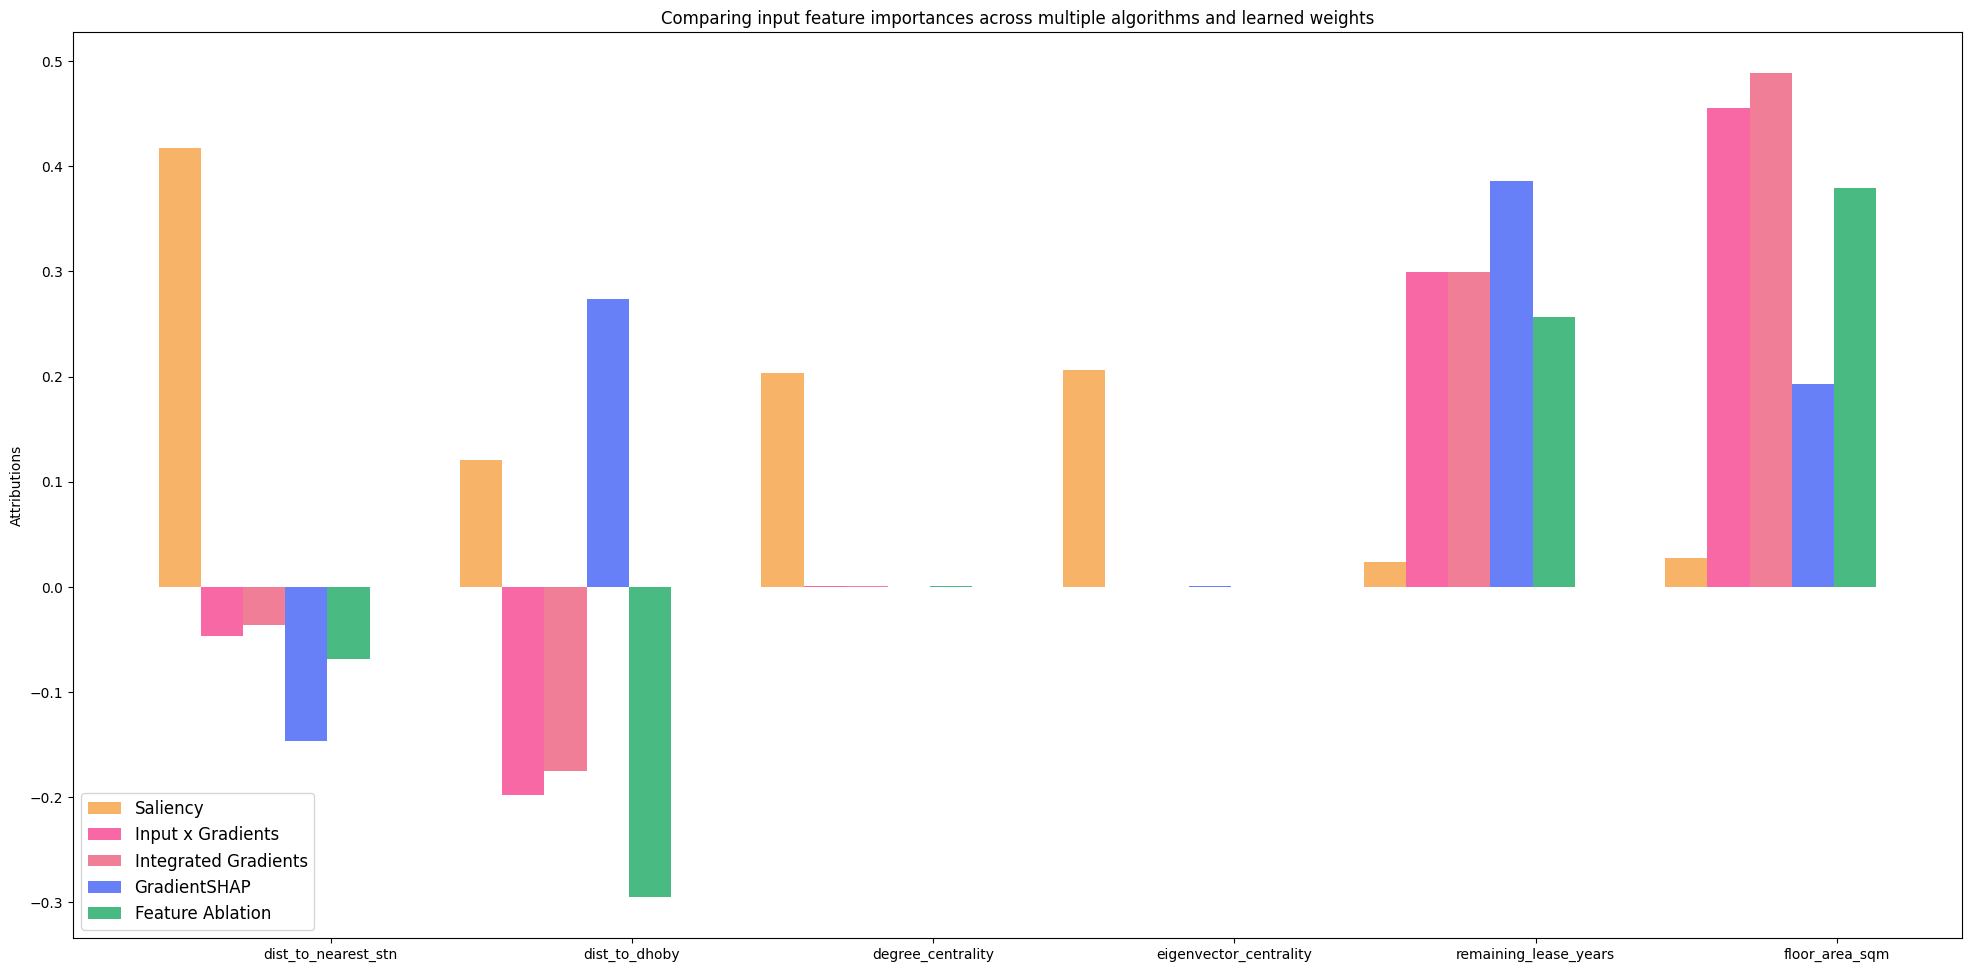

In [9]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

3.Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [10]:
# YOUR CODE HERE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = torch.tensor(scaled_X_train).float()

scaled_X_val = scaler.transform(X_val)
scaled_X_val = torch.tensor(scaled_X_val).float()

scaled_X_test = scaler.transform(X_test)
scaled_X_test = torch.tensor(scaled_X_test).float()

# Create data loaders
train_dataset = TensorDataset(scaled_X_train, y_train)
val_dataset = TensorDataset(scaled_X_val, y_val)
test_dataset = TensorDataset(scaled_X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = HDBResaleModel(scaled_X_train.shape[1], size_hidden1, size_hidden2, size_hidden3, no_labels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train(model, num_epochs, optimizer, criterion, train_loader)

Epoch [1]/[100] running accumulative loss across all batches: 216287035670528.000
Epoch [21]/[100] running accumulative loss across all batches: 4211067046400.000
Epoch [41]/[100] running accumulative loss across all batches: 3735236849792.000
Epoch [61]/[100] running accumulative loss across all batches: 3554195228800.000
Epoch [81]/[100] running accumulative loss across all batches: 3453992670976.000


In [11]:
sal = Saliency(model)
ixg = InputXGradient(model)
ig = IntegratedGradients(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

sal_attr_test = sal.attribute(X_test)
ixg_attr_test = ixg.attribute(X_test)
ig_attr_test = ig.attribute(X_test, n_steps=50)
baseline = torch.zeros_like(X_train, requires_grad=False)
gs_attr_test = gs.attribute(X_test, baseline)
fa_attr_test = fa.attribute(X_test)

/Users/ngtzekean/Github/SC4001-Neural-Network-Deep-Learning/.venv/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


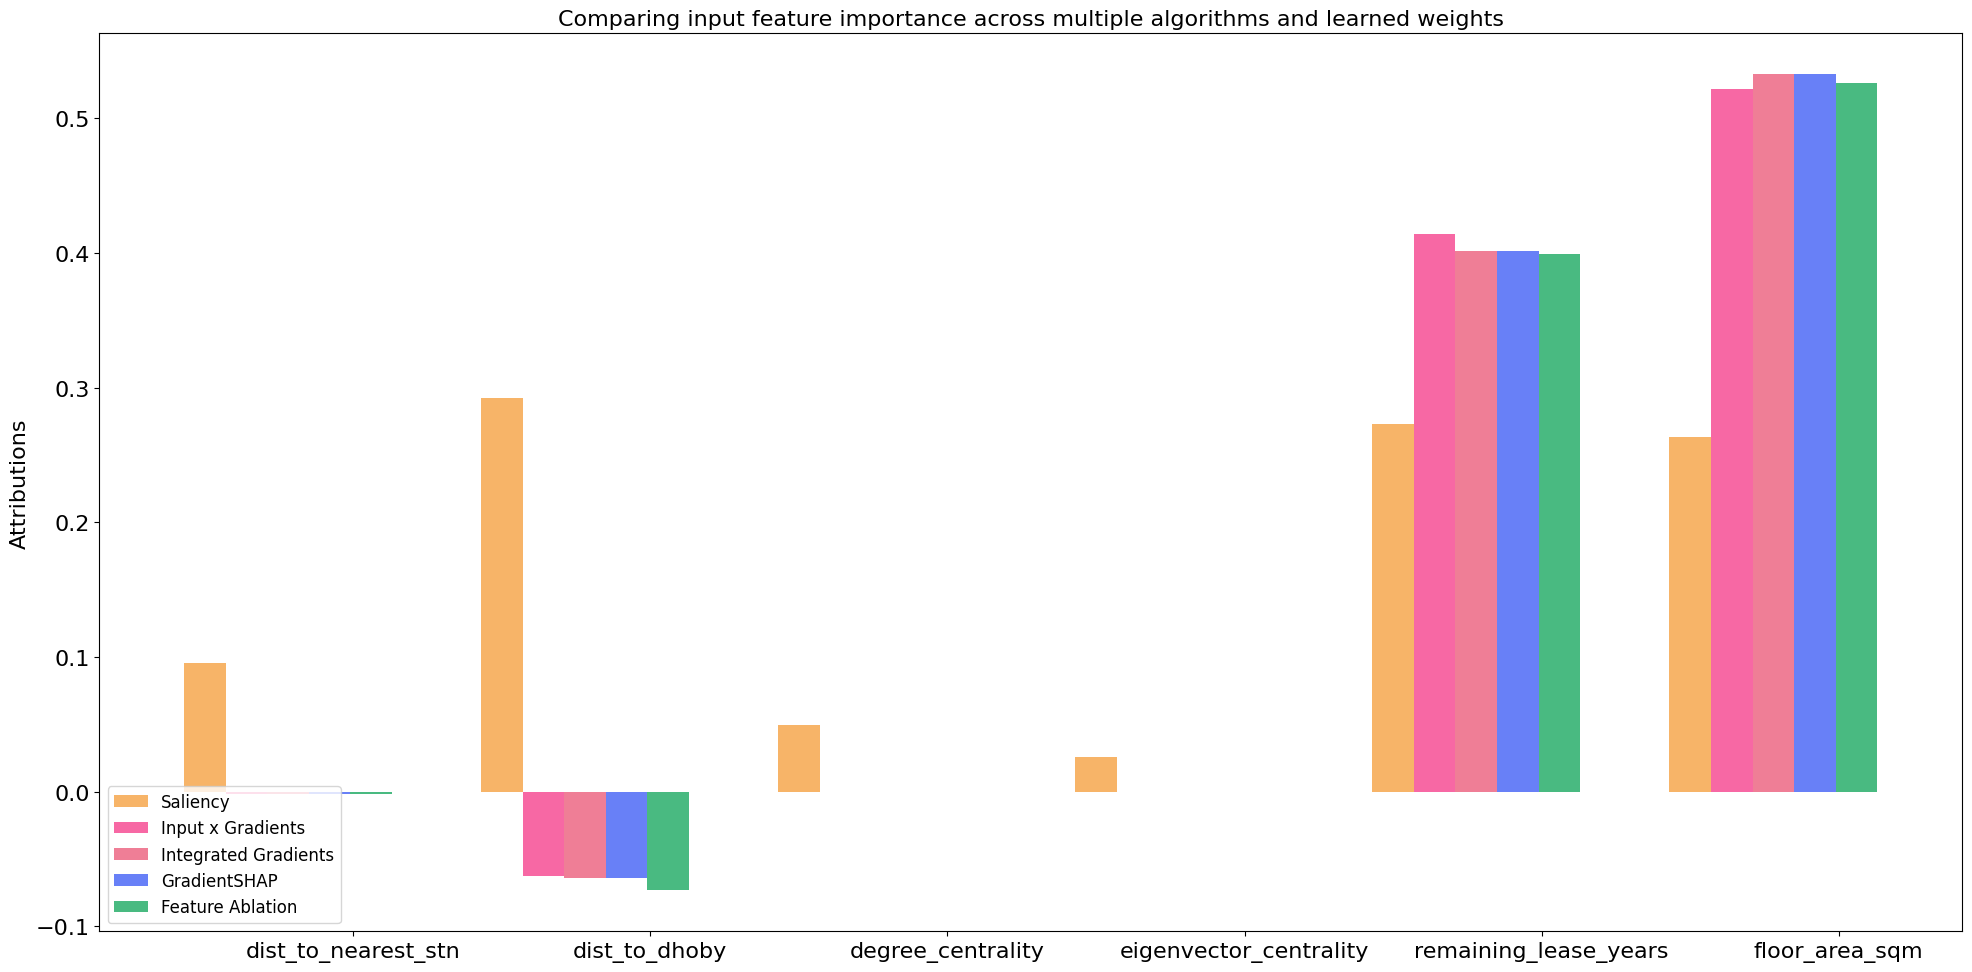

In [12]:
import matplotlib.pyplot as plt

feature_names = train_data.drop(target, axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

sal_attr_test_sum = sal_attr_test.detach().numpy().sum(0)
sal_attr_test_norm_sum = sal_attr_test_sum / np.linalg.norm(sal_attr_test_sum, ord=1)

ixg_attr_test_sum = ixg_attr_test.detach().numpy().sum(0)
ixg_attr_test_norm_sum = ixg_attr_test_sum / np.linalg.norm(ixg_attr_test_sum, ord=1)

ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)

gs_attr_test_sum = gs_attr_test.detach().numpy().sum(0)
gs_attr_test_norm_sum = gs_attr_test_sum / np.linalg.norm(gs_attr_test_sum, ord=1)

fa_attr_test_sum = fa_attr_test.detach().numpy().sum(0)
fa_attr_test_norm_sum = fa_attr_test_sum / np.linalg.norm(fa_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency','Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importance across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)           
plt.rc('axes', titlesize=FONT_SIZE)      
plt.rc('axes', labelsize=FONT_SIZE)      
plt.rc('legend', fontsize=FONT_SIZE - 4) 

ax.bar(x_axis_data, sal_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5a142')
ax.bar(x_axis_data + width, ixg_attr_test_norm_sum, width, align='center', alpha=0.8, color='#f5428d')
ax.bar(x_axis_data + 2 * width, ig_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + 3 * width, gs_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, fa_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

In [13]:
"""
Key Observations:
- GradientSHAP attribution scores remain directionally consistent after feature scaling.
- The magnitude of certain attribution scores (e.g., 'dist_to_dhoby') decreased, while others (e.g., 'remaining_lease_years' and 'floor_area_sqm') increased.
- Feature scaling using StandardScaler changes the input distribution, affecting the baseline used by GradientSHAP.

Explanation:
Baseline Dependence: GradientSHAP's attribution scores are calculated relative to a baseline. By standardizing the features, you effectively change the input distribution, which in turn alters the baseline used by GradientSHAP. This can lead to changes in the magnitude of the attribution scores.
Feature Sensitivity: The sensitivity of a feature to the model's output can be affected by its distribution. If a feature becomes more or less spread out after scaling, it may have a greater or lesser impact on the model's predictions, leading to corresponding changes in the attribution scores.
"""

"\nKey Observations:\n- GradientSHAP attribution scores remain directionally consistent after feature scaling.\n- The magnitude of certain attribution scores (e.g., 'dist_to_dhoby') decreased, while others (e.g., 'remaining_lease_years' and 'floor_area_sqm') increased.\n- Feature scaling using StandardScaler changes the input distribution, affecting the baseline used by GradientSHAP.\n\nExplanation:\nBaseline Dependence: GradientSHAP's attribution scores are calculated relative to a baseline. By standardizing the features, you effectively change the input distribution, which in turn alters the baseline used by GradientSHAP. This can lead to changes in the magnitude of the attribution scores.\nFeature Sensitivity: The sensitivity of a feature to the model's output can be affected by its distribution. If a feature becomes more or less spread out after scaling, it may have a greater or lesser impact on the model's predictions, leading to corresponding changes in the attribution scores.\n"

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

4.Why did Saliency produce scores similar to IG?


In [14]:
# YOUR ANSWER HERE
"""
Key Observations:

- Saliency and IG produce different scores for the same features, even when trained on scaled or non-scaled datasets.
- The similarity between Saliency and IG depends on the consistency of gradients along the baseline-to-input path.
- A baseline set to zero might be distant from the input distribution for certain features, leading to discrepancies in attribution scores.
- Scaling the dataset can reduce the discrepancy between Saliency and IG values, possibly due to bringing the baseline closer to the input distribution.
- IG's ability to capture non-linear relationships can contribute to the discrepancy, as it may assign higher importance to features that have a disproportionate impact on the output.

Potential Explanations and Further Exploration:
Data-Driven Baselines: Consider using data-driven baselines (e.g., mean or median of the input distribution) to ensure a more representative baseline for all features.
Feature-Specific Baselines: Experiment with feature-specific baselines to account for differences in feature distributions.
Feature Interactions: Explore feature interactions that might be missed by Saliency but captured by IG.
Feature Engineering: Consider creating new features that capture non-linear relationships more effectively.
Larger Datasets: Investigate if increasing the dataset size can help reduce the discrepancy between Saliency and IG, as a larger dataset might provide a more representative distribution.
Model Complexity: Evaluate if the complexity of the model (e.g., number of layers, hidden units) affects the discrepancy. A more complex model might be better able to capture non-linear relationships.
Different Scaling Methods: Experiment with different scaling methods (e.g., min-max normalization, standardization) to see if they have a significant impact on the discrepancy.
"""

"\nKey Observations:\n\n- Saliency and IG produce different scores for the same features, even when trained on scaled or non-scaled datasets.\n- The similarity between Saliency and IG depends on the consistency of gradients along the baseline-to-input path.\n- A baseline set to zero might be distant from the input distribution for certain features, leading to discrepancies in attribution scores.\n- Scaling the dataset can reduce the discrepancy between Saliency and IG values, possibly due to bringing the baseline closer to the input distribution.\n- IG's ability to capture non-linear relationships can contribute to the discrepancy, as it may assign higher importance to features that have a disproportionate impact on the output.\n\nPotential Explanations and Further Exploration:\nData-Driven Baselines: Consider using data-driven baselines (e.g., mean or median of the input distribution) to ensure a more representative baseline for all features.\nFeature-Specific Baselines: Experiment wi

5.Why did Input x Gradients give the same attribution scores as IG?


In [15]:
# YOUR ANSWER HERE
"""
Key Observations:
- Both Input x Gradients and Integrated Gradients provide similar attribution scores, but there are noticeable differences.
- A small difference between the baseline and input might lead to less variation in gradients, resulting in minimal differences between the two methods.
- Scaling the dataset can further reduce the discrepancy between Input x Gradients and Integrated Gradients, likely due to bringing the baseline closer to the input distribution.

Potential Explanations:
Gradient Consistency: If the gradients are relatively consistent along the baseline-to-input path, the integral in Integrated Gradients might not significantly deviate from the direct gradient calculation in Input x Gradients. This could explain the similarity in their results.
Scaling Effect: Scaling the dataset can standardize the input distribution, making the baseline more representative. This might reduce the impact of the baseline-input difference on the gradient calculations.
Model Complexity: The complexity of the model (e.g., number of layers, hidden units) can also influence the similarity between Input x Gradients and Integrated Gradients. A simpler model might have more linear relationships, making the gradients more consistent.
Feature Interactions: Complex feature interactions might be better captured by Integrated Gradients, leading to slightly different attribution scores compared to Input x Gradients.
"""

'\nKey Observations:\n- Both Input x Gradients and Integrated Gradients provide similar attribution scores, but there are noticeable differences.\n- A small difference between the baseline and input might lead to less variation in gradients, resulting in minimal differences between the two methods.\n- Scaling the dataset can further reduce the discrepancy between Input x Gradients and Integrated Gradients, likely due to bringing the baseline closer to the input distribution.\n\nPotential Explanations:\nGradient Consistency: If the gradients are relatively consistent along the baseline-to-input path, the integral in Integrated Gradients might not significantly deviate from the direct gradient calculation in Input x Gradients. This could explain the similarity in their results.\nScaling Effect: Scaling the dataset can standardize the input distribution, making the baseline more representative. This might reduce the impact of the baseline-input difference on the gradient calculations.\nMo